./ESC-50-master/:
audio  esc50.gif  LICENSE  meta  pytest.ini  README.md	requirements.txt  tests

./ESC-50-master/audio:
1-100032-A-0.wav   2-100648-A-43.wav  3-100018-A-18.wav  4-102844-A-49.wav  5-103415-A-2.wav
1-100038-A-14.wav  2-100786-A-1.wav   3-100024-A-27.wav  4-102844-B-49.wav  5-103416-A-2.wav
1-100210-A-36.wav  2-101676-A-10.wav  3-100024-B-27.wav  4-102844-C-49.wav  5-103418-A-2.wav
1-100210-B-36.wav  2-102414-A-17.wav  3-101381-A-33.wav  4-102871-A-42.wav  5-103420-A-2.wav
1-101296-A-19.wav  2-102414-B-17.wav  3-101381-B-33.wav  4-107117-A-33.wav  5-103421-A-2.wav
1-101296-B-19.wav  2-102414-C-17.wav  3-102583-A-49.wav  4-107120-A-33.wav  5-103422-A-2.wav
1-101336-A-30.wav  2-102414-D-17.wav  3-102583-B-49.wav  4-107122-A-33.wav  5-117118-A-42.wav
1-101404-A-34.wav  2-102414-E-17.wav  3-102583-C-49.wav  4-108352-A-33.wav  5-117120-A-42.wav
1-103298-A-9.wav   2-102414-F-17.wav  3-102908-A-4.wav	 4-111671-A-42.wav  5-117122-A-42.wav
1-103995-A-30.wav  2-102414-G-17.wav  3-

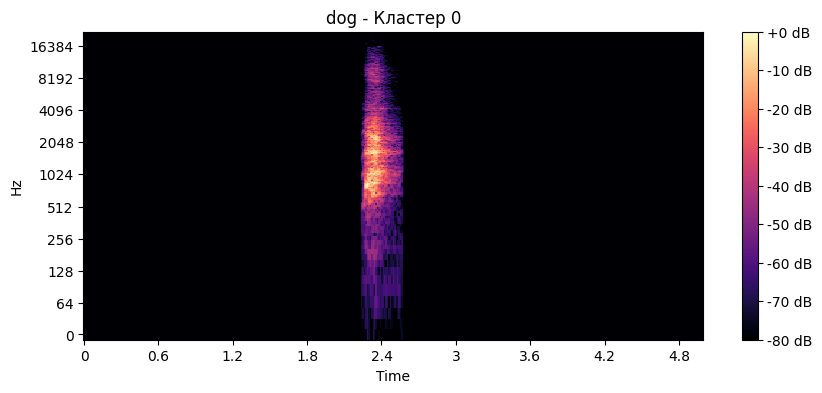

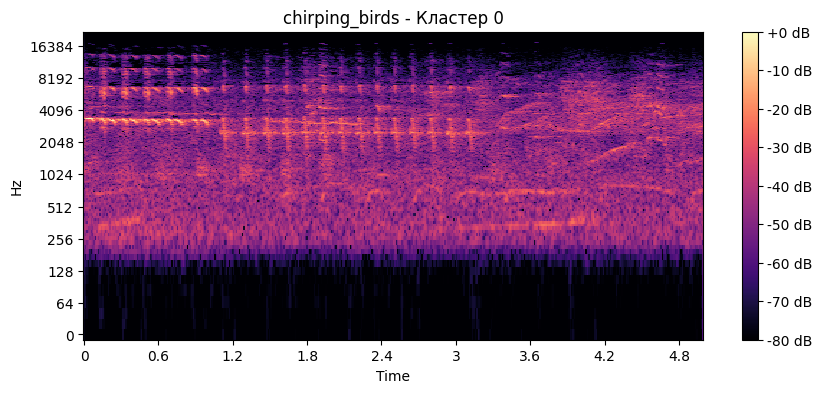

Кластер 1: ['chirping_birds' 'dog']


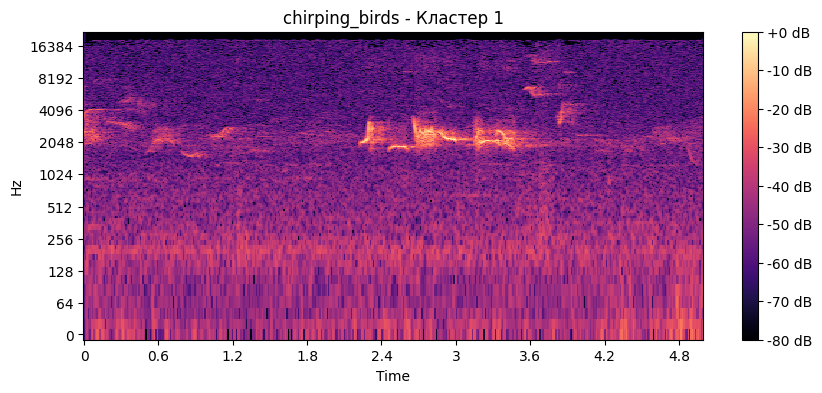

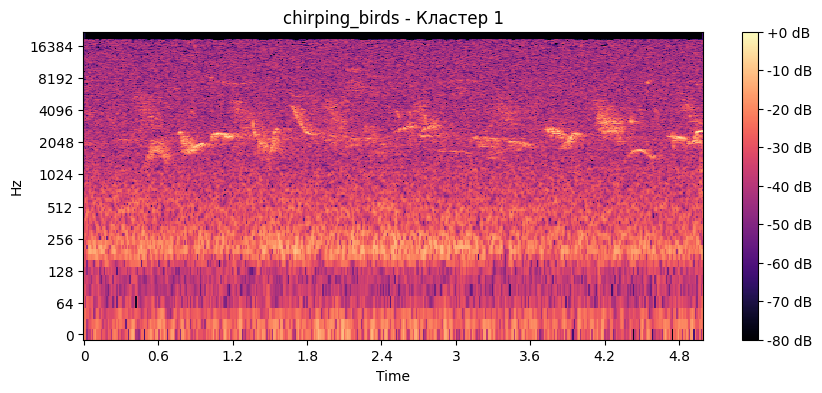

Висновки:
1. Звуки із різних категорій ('dog', 'chirping_birds') здебільшого потрапляють у різні кластери.
2. Перетворення Фур'є дозволяє ефективно вилучати частотні ознаки, які добре підходять для кластеризації.
3. Пулінг зменшує розмірність спектрограм, що прискорює обчислення без втрати ключової інформації.


In [2]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from urllib.request import urlretrieve
from IPython.display import Audio
import zipfile

# Завантаження та розархівування датасету
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("./")
    os.remove(zip_file_path)

# Перевірка структури після розархівування
!ls -R ./ESC-50-master/

# Завантаження мета-інформації
metadata_path = './ESC-50-master/meta/esc50.csv'
df = pd.read_csv(metadata_path)

# Вибірка звуків із мітками 'dog' та 'chirping_birds'
selected_labels = ['dog', 'chirping_birds']
filtered_df = df[df['category'].isin(selected_labels)].reset_index(drop=True)

# Функція для побудови спектрограми
def generate_spectrogram(file_path, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    return spectrogram, sr

# Функція для зменшення розміру спектрограми (пулінг)
def pooling(spectrogram, pool_size=(2, 2)):
    pooled = spectrogram[:len(spectrogram) // pool_size[0] * pool_size[0], :len(spectrogram[0]) // pool_size[1] * pool_size[1]]
    return pooled.reshape(pooled.shape[0] // pool_size[0], pool_size[0], -1, pool_size[1]).mean(axis=(1, 3))

# Обробка обраних звуків
spectrograms = []
labels = []
for _, row in filtered_df.iterrows():
    file_path = os.path.join(download_path, "audio", row['filename'])
    spectrogram, sr = generate_spectrogram(file_path)
    pooled_spectrogram = pooling(spectrogram)
    flattened_spectrogram = pooled_spectrogram.flatten()
    spectrograms.append(flattened_spectrogram)
    labels.append(row['category'])

# Масштабування ознак
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectrograms)

# Кластеризація за допомогою SpectralClustering
n_clusters = len(selected_labels)
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
cluster_labels = clustering.fit_predict(scaled_data)

# Аналіз кластерів
filtered_df['cluster'] = cluster_labels

# Візуалізація спектрограм перших кількох звуків із кожного кластеру
for cluster_id in range(n_clusters):
    cluster_subset = filtered_df[filtered_df['cluster'] == cluster_id]
    print(f"Кластер {cluster_id}: {cluster_subset['category'].unique()}")
    for _, row in cluster_subset.head(2).iterrows():
        file_path = os.path.join(download_path, "audio", row['filename'])
        y, sr = librosa.load(file_path, sr=None)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{row['category']} - Кластер {cluster_id}")
        plt.show()

# Висновки
print("Висновки:")
print("1. Звуки із різних категорій ('dog', 'chirping_birds') здебільшого потрапляють у різні кластери.")
print("2. Перетворення Фур'є дозволяє ефективно вилучати частотні ознаки, які добре підходять для кластеризації.")
print("3. Пулінг зменшує розмірність спектрограм, що прискорює обчислення без втрати ключової інформації.")
